In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    ConfusionMatrixDisplay, precision_recall_curve
)

from xgboost import XGBClassifier

In [2]:
# Load and combine dataset
train_df = pd.read_csv("phishing_url_train.csv")
test_df = pd.read_csv("phishing_url_test.csv")
df_all = pd.concat([train_df, test_df], ignore_index=True)

# Drop 'url' column if it exists
if 'url' in df_all.columns:
    df_all.drop(columns=['url'], inplace=True)

# Encode labels
status_map = {'legitimate': 0, 'phishing': 1}
df_all["status"] = df_all["status"].map(status_map)

In [3]:
# Feature set
url_based_features = [
    "length_url", "length_hostname", "nb_dots", "nb_hyphens", "nb_at", "nb_qm",
    "nb_eq", "nb_underscore", "nb_percent", "nb_slash", "nb_www", "nb_com",
    "https_token", "ratio_digits_url", "ratio_digits_host", "tld_in_subdomain",
    "prefix_suffix", "random_domain", "shortening_service", "nb_redirection",
    "length_words_raw", "char_repeat", "shortest_words_raw", "shortest_word_host",
    "shortest_word_path", "longest_words_raw", "longest_word_host", "longest_word_path",
    "avg_words_raw", "avg_word_host", "avg_word_path", "phish_hints",
    "domain_in_brand", "suspecious_tld"
]

X = df_all[url_based_features]
y = df_all["status"]

In [4]:
# Train/test split (reshuffled)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# XGBoost model
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    max_depth=4,
    min_child_weight=5,
    gamma=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1.0,
    n_estimators=200,
    learning_rate=0.05
)

# Cross-validation
f1_cv = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring='f1')
print(f"\nMean F1 (CV): {f1_cv.mean():.4f} ± {f1_cv.std():.4f}")

# Train
xgb_model.fit(X_train_scaled, y_train)

/home/astrin/.conda/envs/astrin/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:39:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/astrin/.conda/envs/astrin/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:39:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/astrin/.conda/envs/astrin/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:39:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/astrin/.conda/envs/astrin/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:39:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/astrin/.conda/envs/astrin/lib/python3.12/site-packages/xgboost


Mean F1 (CV): 0.8970 ± 0.0081


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [6]:
# Test predictions
y_pred = xgb_model.predict(X_test_scaled)
y_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

print("\n--- Test Set Metrics ---")
print(f"Accuracy      : {accuracy:.4f}")
print(f"Precision     : {precision:.4f}")
print(f"Recall        : {recall:.4f}")
print(f"F1 Score      : {f1:.4f}")
print(f"ROC AUC       : {roc_auc:.4f}")
print(f"PR AUC        : {avg_precision:.4f}")


--- Test Set Metrics ---
Accuracy      : 0.9055
Precision     : 0.9105
Recall        : 0.8994
F1 Score      : 0.9049
ROC AUC       : 0.9656
PR AUC        : 0.9677


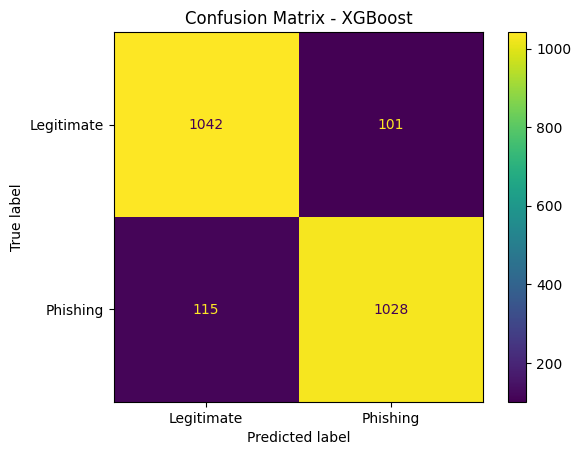

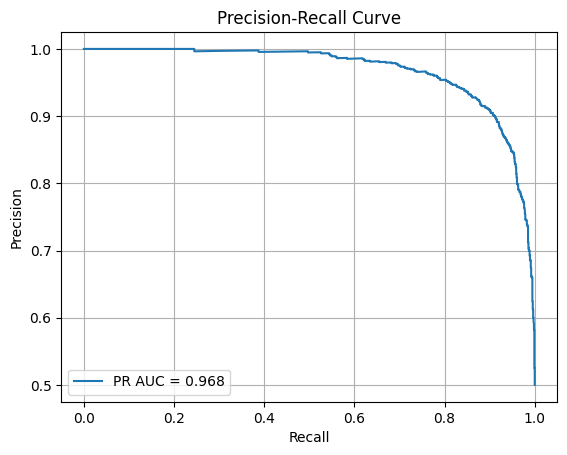

In [7]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Phishing"])
disp.plot()
plt.title("Confusion Matrix - XGBoost")
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall_vals, precision_vals, label=f"PR AUC = {avg_precision:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Learning Curve
def plot_learning_curve(estimator, title, X, y, cv, scoring='f1'):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y,
        cv=cv,
        scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1,
        shuffle=True,
        random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', label="Train F1", color="blue")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
    plt.plot(train_sizes, test_mean, 'o-', label="CV F1", color="green")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="green")
    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("F1 Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/home/astrin/.conda/envs/astrin/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:40:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/astrin/.conda/envs/astrin/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:40:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/astrin/.conda/envs/astrin/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:40:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/astrin/.conda/envs/astrin/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:40:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/astrin/.conda/envs/astrin/lib/python3.12/site-packages/xgboost

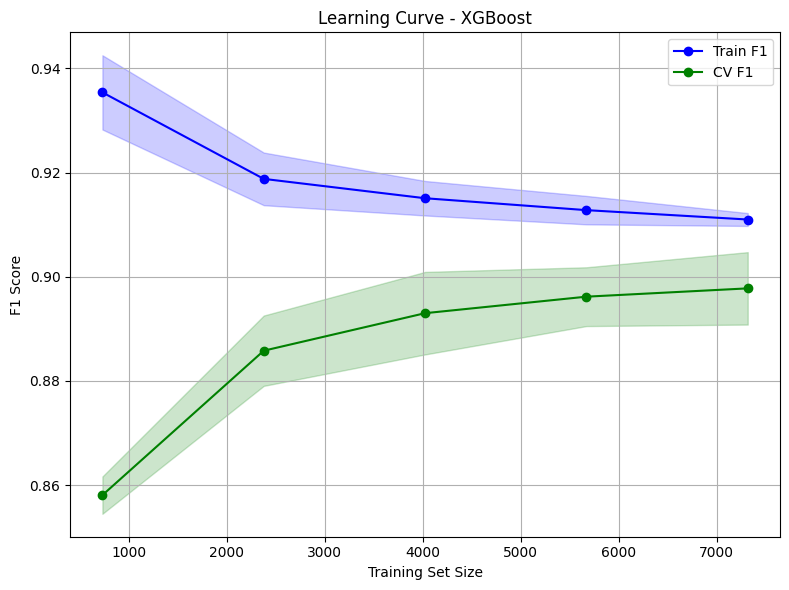

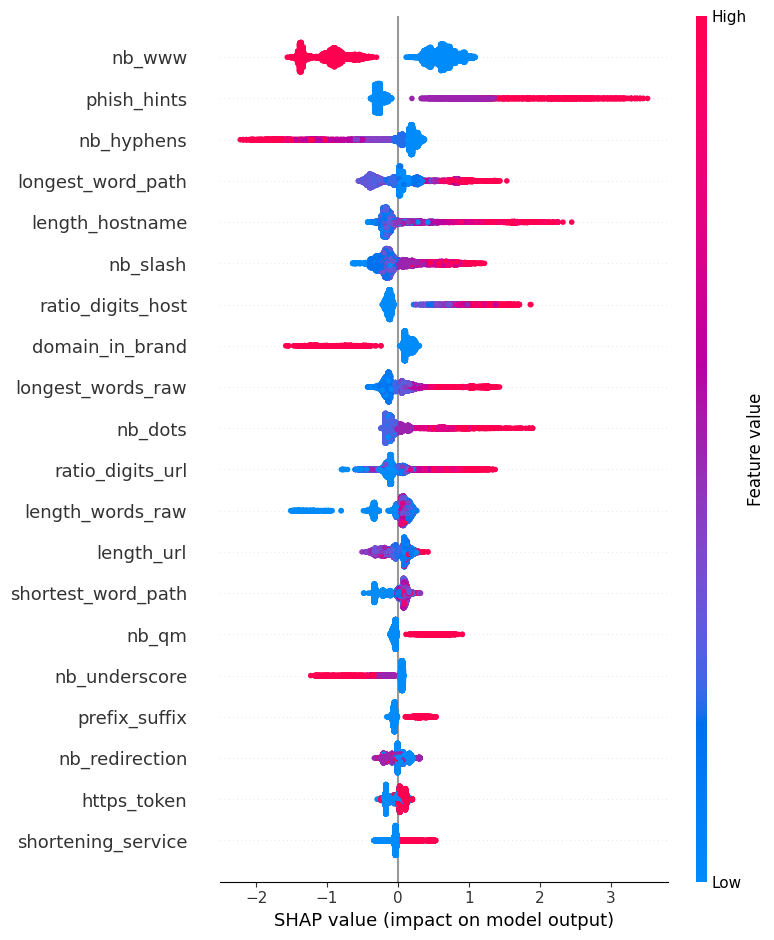

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve(xgb_model, "Learning Curve - XGBoost", X_train_scaled, y_train, cv=cv)

# SHAP explainability
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_scaled)
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)
